In [66]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from os import path
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from copy import copy
from util_svm import *
#from timeit import default_timer as timer

### Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # 16 # 8 # HOG pixels per cell
cell_per_block = 1 # 2 # HOG cells per block, which can handel e.g. shadows
hog_channel = 0 #'ALL' # Can be 0, 1, 2, or 'ALL'
spatial_size = (16, 16) # (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # True # Spatial features on or off
hist_feat = True # True # Histogram features on or off
hog_feat = True # HOG features on or off
clf_path = 'car_svc_pickle.p'  # if classifier exist

# Read in cars and notcars
cars = glob.glob('train_images/vehicles/**/*.png')
notcars = glob.glob('train_images/non-vehicles/**/*.png')

# set the sample size
sample_size = min(len(cars), len(notcars))
print('cars - ',len(cars))
print('notcars - ',len(notcars))
print('sample size - ', sample_size)

cars -  8792
notcars -  8968
sample size -  8792


In [7]:
print('extracting car features...')
car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('car features extracted!')
print('extracting noncar features...')
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
print('noncar features extracted!')



extracting car features...


C:\Apps\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


car features extracted!
extracting noncar features...
noncar features extracted!


In [9]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0,100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=40)

print("Training set complete with ",len(X_train)," samples")

Training set complete with  14208  samples


Text(0.5,1,'Best setting C=0.001273')

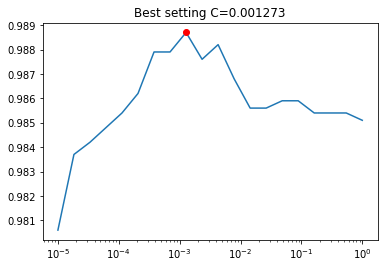

In [11]:
#
# Train & test a classifier
#
import time
import matplotlib.pyplot as plt
%matplotlib inline

pts = []
for C in np.logspace(-5, -0.001, 20):
    svc = LinearSVC(C=C)
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    score = round(svc.score(X_test, y_test), 4)
    pts.append([C, score])
    
winner = pts[np.argmax(pts, axis=0)[1]]
plt.semilogx([x[0] for x in pts], [x[1] for x in pts])
plt.semilogx([winner[0]], [winner[1]], linestyle='--', marker='o', color='r')
plt.title("Best setting C={:f}".format(winner[0]))

In [12]:
svc =  LinearSVC(C=0.0013) # , loss='hinge')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


0.84 Seconds to train SVC...
Test Accuracy of SVC =  0.9887


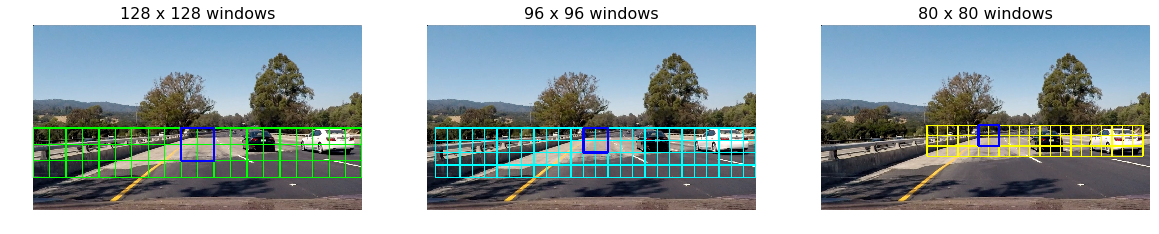

In [61]:
def show_images_in_table (images, table_size, fig_size = (10, 10), cmap=None, titles=None):
    """Shows images in table
    Args:
        images (list): list of input images
        table_size (tuple): (cols count, rows count)
        fig_size (tuple): picture (size x, size y) in inches
        cmap (list): list of cmap parameters for each image
        titles (list): list of images titles
    """
    sizex = table_size [0]
    sizey = table_size [1]
    fig, imtable = plt.subplots (sizey, sizex, figsize = fig_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx = i + j*sizex
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                im = images[im_idx]
                if len(im.shape) == 3:
                    imtable [j][i].imshow (im)
                else:
                    imtable [j][i].imshow (im, cmap='hot') #gray')
            imtable [j][i].axis('off')
            if not titles is None:
                imtable [j][i].set_title (titles [im_idx], fontsize=16)

    plt.show ()



# defining parameters of sliding windows
# I use 3 sliding windows with different sizes, and different positions

image = mpimg.imread('test_images/test_image.jpg')
window_img = np.copy(image)

sw_x_limits = [
    [None, None],
    [32, None],
    [412, 1280]
]

sw_y_limits = [
    [400, 640],
    [400, 600],
    [390, 540]
]

sw_window_size = [
    (128, 128),
    (96, 96),
    (80, 80)
]

sw_overlap = [
    (0.5, 0.5),
    (0.5, 0.5),
    (0.5, 0.5)
]

# create sliding windows
windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

# show sliding windows
sliding_windows = []
sliding_windows.append (draw_boxes(np.copy(image), windows, color=(0, 255, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows2, color=(0, 255, 255), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows3, color=(255,2550, 0), thick=4))

# drawing one of sliding windows in blue
sliding_windows [0] = draw_boxes (sliding_windows [0], [windows[9]], color=(0, 0, 255), thick=8)
sliding_windows [1] = draw_boxes (sliding_windows [1], [windows2[12]], color=(0, 0, 255), thick=8)
sliding_windows [2] = draw_boxes (sliding_windows [2], [windows3[5]], color=(0, 0, 255), thick=8)

sw_titles = [
    '128 x 128 windows',
    '96 x 96 windows',
    '80 x 80 windows'
]

show_images_in_table (sliding_windows, (3, 1), fig_size=(20, 14), titles=sw_titles)

C:\Apps\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


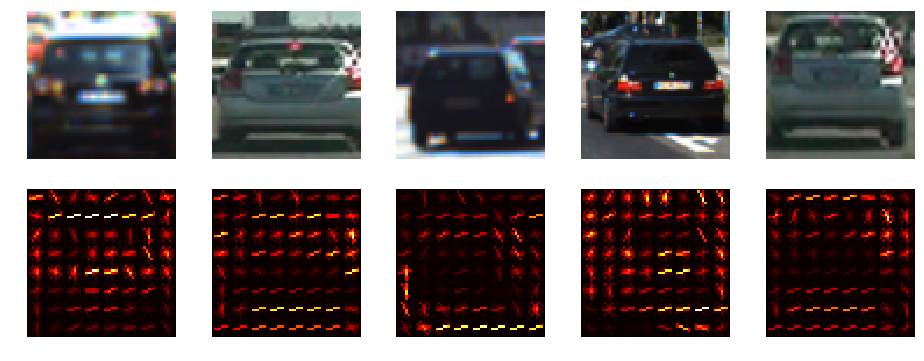

In [62]:
import random
a=[21, 4424, 123, 300, 999]

car_image = []
for idx in a:
    #img=mpimg.imread(cars[idx])
    car_image.append(mpimg.imread(cars[idx]))

hogs = []
for im in car_image:
    im = convert_color(im, color='YCrCb')
    features, hog_image = get_hog_features(im[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
    hogs.append (hog_image)
    
car_image.extend(hogs)
    
show_images_in_table (car_image, (5, 2), fig_size=(16, 6))

C:\Apps\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


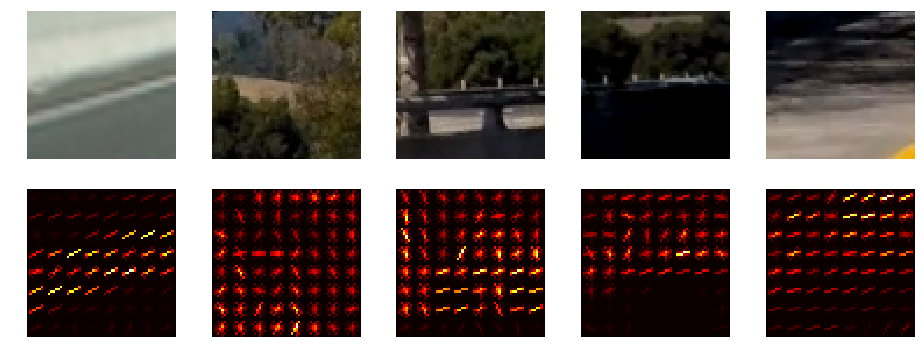

In [63]:
notcar_image = []
for idx in a:
    #img=mpimg.imread(notcars[idx])
    notcar_image.append(mpimg.imread(notcars[idx]))

hogs = []
for im in notcar_image:
    im = convert_color(im, color='YCrCb')
    features, hog_image = get_hog_features(im[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
    hogs.append (hog_image)
    
notcar_image.extend(hogs)
    
show_images_in_table (notcar_image, (5, 2), fig_size=(16, 6))

In [64]:
def get_hot_boxes (image):
    """Applies sliding windows to images
    and finds hot windows. Also returns image with all hot boxes are drawn
    Args:
        image (numpy.array): image
    Returns:
        hot_windows(list), image_with_hot_windows_drawn(numpy.array)
    """

    dst = np.copy (image)
    all_hot_windows = []
    
    # iterate over previousely defined sliding windows
    for x_limits, y_limits, window_size, overlap in zip (sw_x_limits, sw_y_limits, sw_window_size, sw_overlap):

        windows = slide_window(
            dst,
            x_start_stop=x_limits,
            y_start_stop=y_limits, 
            xy_window=window_size,
            xy_overlap=overlap
        )

        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
        
        all_hot_windows.extend (hot_windows)

        dst = draw_boxes(dst, hot_windows, color=(0, 0, 1), thick=4)

    return all_hot_windows, dst
        
def get_heat_map(image, bbox_list):
    """Computes heat map of hot windows. Puts all specified
    hot windows on top of each other, so every pixel of returned image will
    contain how many hot windows covers this pixel
    Args:
        image (numpy.array): image
    Returns:
        heatmap (numpy.array) grayscale image of the same size as input image
    """

    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

C:\Apps\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


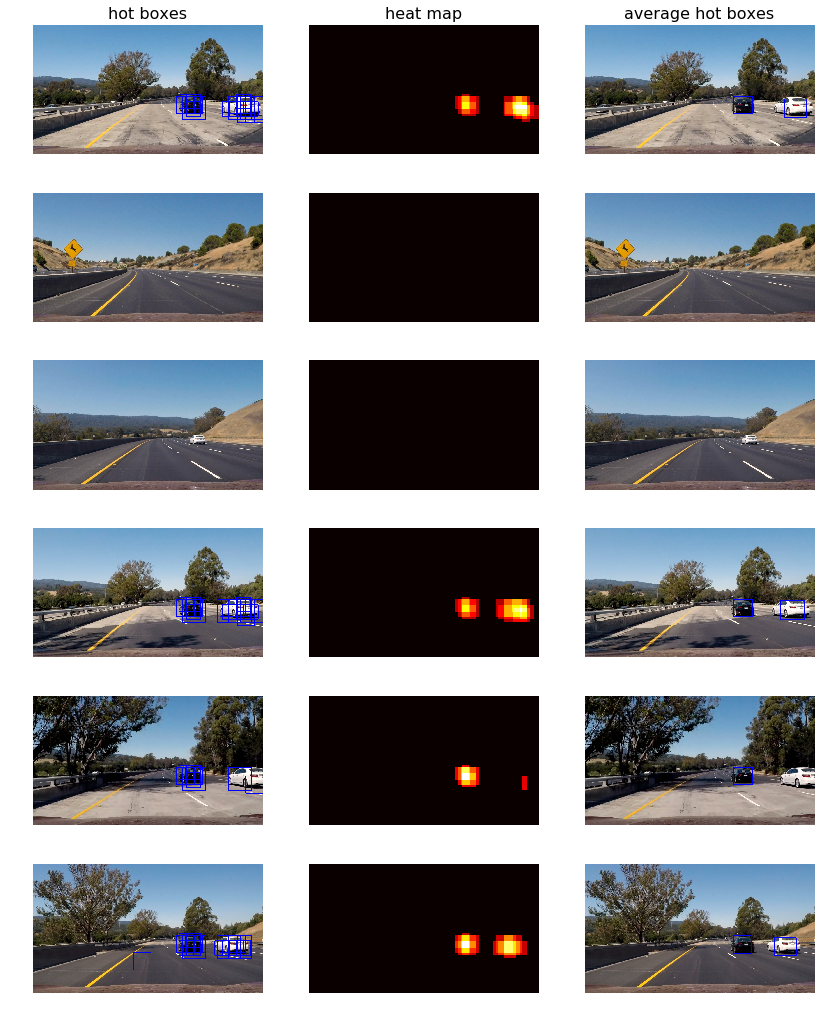

In [67]:
# algorithm demonstration on test images

test_images = []
test_images_titles = []

for impath in glob.glob('test_images/test*.jpg'):
    image_orig = mpimg.imread(impath)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image_orig.astype(np.float32)/255

    # hot boxes
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image)
    # heat map
    heat_map = generate_heatmap(image, hot_boxes) # get_heat_map(image, hot_boxes)
#     labels = label(heat_map)
#     draw_img = draw_labeled_bboxes(np.copy(img), labels)

    
    # average boxes
    avg_boxes = calc_average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    
    test_images.append (image_with_hot_boxes)
    test_images.append (heat_map)
    test_images.append (image_with_boxes)
    
    test_images_titles.extend (['', '', ''])
    
test_images_titles [0] = 'hot boxes'
test_images_titles [1] = 'heat map'
test_images_titles [2] = 'average hot boxes'

show_images_in_table (test_images, (3, 6), fig_size=(14, 18), titles=test_images_titles, cmap='hot')